# Cargamos los Datos

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = r"C:\Users\Mi Pc\Documents\IntegradorProject" 


In [ ]:
# Primero cargo las tablas pequeñas 
products   = pd.read_csv(f"{base_path}\\products.csv")
employees  = pd.read_csv(f"{base_path}\\employees.csv")
customers  = pd.read_csv(f"{base_path}\\customers.csv")
cities     = pd.read_csv(f"{base_path}\\cities.csv")
countries  = pd.read_csv(f"{base_path}\\countries.csv")
categories = pd.read_csv(f"{base_path}\\categories.csv")

# Aseguro tipos básicos
products['Price'] = pd.to_numeric(products['Price'], errors='coerce')
employees['BirthDate'] = pd.to_datetime(employees['BirthDate'], errors='coerce')
employees['HireDate']  = pd.to_datetime(employees['HireDate'], errors='coerce')


Cargadas tablas pequeñas. Filas:  products: 452 employees: 23 categories: 11


#### Usaremos chunks para cargar los datos de "Sales" ya que es muy voluminoso ####
##### He aprovechado el proceso de cargado de datos para crear a la par una nueva column la cual incluya 'TotalPriceCalculated' lo cual considero es mas rentable para el desgaste de memoria #####

In [47]:

# Tamaño de bloque para leer el CSV por partes
chunk_size = 100_000
chunks = []

# Para no saturar memoria
for i, chunk in enumerate(pd.read_csv(f"{base_path}\\sales.csv", chunksize=chunk_size)):

    # Asegurar que las columnas numéricas estén limpias
    chunk['Quantity'] = pd.to_numeric(chunk['Quantity'], errors='coerce').fillna(0)
    chunk['Discount'] = pd.to_numeric(chunk['Discount'], errors='coerce').fillna(0)

    # Traer el precio unitario desde la tabla de productos
    chunk = chunk.merge(products[['ProductID', 'Price']], on='ProductID', how='left')

    # Calcular el valor total real de cada venta
    chunk['Price'] = pd.to_numeric(chunk['Price'], errors='coerce').fillna(0)
    chunk['TotalPriceCalculated'] = (chunk['Quantity'] * chunk['Price']) * (1 - chunk['Discount'])

    # Guardar el bloque procesado
    chunks.append(chunk)

# Unir todos los bloques en un solo DataFrame
sales = pd.concat(chunks, ignore_index=True)
print(f" Archivo 'sales' cargado con {len(sales):,} filas totales.")


 Archivo 'sales' cargado con 6,758,125 filas totales.


# Estructuracción de Datos

#### Vamos a analizar los datos que tenemos almancenados en las tablas guardadas ####

In [17]:
print(sales.head())

   SalesID  SalesPersonID  CustomerID  ProductID  Quantity  Discount  \
0        1              6       27039        381         7       0.0   
1        2             16       25011         61         7       0.0   
2        3             13       94024         23        24       0.0   
3        4              8       73966        176        19       0.2   
4        5             10       32653        310         9       0.0   

   TotalPrice                SalesDate     TransactionNumber    Price  \
0         0.0  2018-02-05 07:38:25.430  FQL4S94E4ME1EZFTG42G  44.2337   
1         0.0  2018-02-02 16:03:31.150  12UGLX40DJ1A5DTFBHB8  62.5460   
2         0.0  2018-05-03 19:31:56.880  5DT8RCPL87KI5EORO7B0  79.0184   
3         0.0  2018-04-07 14:43:55.420  R3DR9MLD5NR76VO17ULE  81.3167   
4         0.0  2018-02-12 15:37:03.940  4BGS0Z5OMAZ8NDAFHHP3  79.9780   

   TotalPriceCalculated  
0             309.63590  
1             437.82200  
2            1896.44160  
3            1236.01384 

In [69]:
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6758125 entries, 0 to 6758124
Data columns (total 11 columns):
 #   Column                Dtype         
---  ------                -----         
 0   SalesID               int64         
 1   EmployeeID            int64         
 2   CustomerID            int64         
 3   ProductID             int64         
 4   Quantity              int64         
 5   Discount              float64       
 6   TotalPrice            float64       
 7   SalesDate             datetime64[ns]
 8   TransactionNumber     object        
 9   Price                 float64       
 10  TotalPriceCalculated  float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 567.2+ MB
None


#### Eliminamos la columna TotalPrice ya que no contenia datos importantes mas que 0 ####

In [ ]:
sales.drop(columns=['TotalPrice'], inplace=True)

ℹ️ La columna 'TotalPrice' no existe en el DataFrame.


### Revisar nulos en Price y TotalPriceCalculated ###

In [48]:

n_price_null = products['Price'].isna().sum()
n_sales_price_null = sales['Price'].isna().sum()
print("Nulos en products.Price:", n_price_null, " | nulos en sales.Price después merge:", n_sales_price_null)

sales['TotalPriceCalculated'].describe().round(2)


Nulos en products.Price: 0  | nulos en sales.Price después merge: 0


count    6758125.00
mean         638.68
std          547.95
min            0.00
25%          176.94
50%          488.37
75%          982.16
max         2496.89
Name: TotalPriceCalculated, dtype: float64

# Limpieza de datos

#### Primero empezamos unificando el nombre las tables en Sales y Employees ####

In [53]:
sales.rename(columns={"SalesPersonID": "EmployeeID"}, inplace=True)

print("Columna 'SalesPersonID' renombrada a 'EmployeeID'")
sales.head(2)

Columna 'SalesPersonID' renombrada a 'EmployeeID'


,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price,TotalPriceCalculated
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,309.6359
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,437.8220


#### Convertimos los tipos de datos sino estan en formao DateTime ####

In [54]:

sales["SalesDate"] = pd.to_datetime(sales["SalesDate"], errors='coerce')
employees["HireDate"] = pd.to_datetime(employees["HireDate"], errors='coerce')
employees["BirthDate"] = pd.to_datetime(employees["BirthDate"], errors='coerce')

sales.dtypes


SalesID                          int64
EmployeeID                       int64
CustomerID                       int64
ProductID                        int64
Quantity                         int64
Discount                       float64
TotalPrice                     float64
SalesDate               datetime64[ns]
TransactionNumber               object
Price                          float64
TotalPriceCalculated           float64
dtype: object

In [27]:
employees.dtypes

EmployeeID                int64
FirstName                object
MiddleInitial            object
LastName                 object
BirthDate        datetime64[ns]
Gender                   object
CityID                    int64
HireDate         datetime64[ns]
dtype: object

# Validación: Detección y manejo de outliers

#### Detecta los outliers en la columna de ventas totales (TotalPriceCalculated) utilizando el criterio del rango intercuartílico (IQR). Luego, crea una nueva columna llamada IsOutlier que tenga el valor 1 si el registro es un outlier y 0 en caso contrario. ¿Cuántos outliers se detectaron? ####

#### Empezamos calculando IQR para determinar los valores fuera del rango ####

Outliers detectados: 48217 de 6758125 filas (0.713%)


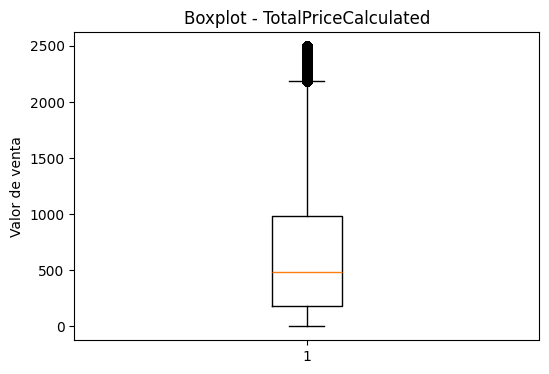

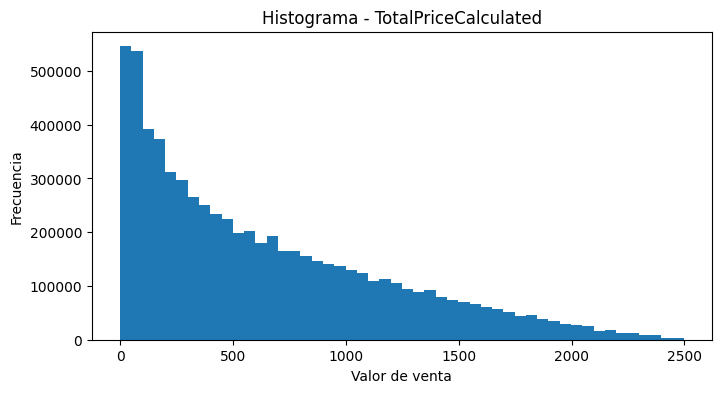

In [ ]:

q1 = sales['TotalPriceCalculated'].quantile(0.25)
q3 = sales['TotalPriceCalculated'].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

# Crear (1 = outlier, 0 = normal)
sales['IsOutlier'] = ((sales['TotalPriceCalculated'] < lower) |  (sales['TotalPriceCalculated'] > upper)).astype(int)

# Cuántos registros son outliers?¿
num_outliers = int(sales['IsOutlier'].sum())
total = len(sales)

print(f"Outliers detectados: {num_outliers} de {total} filas ({num_outliers/total:.3%})")

# Boxplot 
plt.figure(figsize=(6,4))
plt.boxplot(sales['TotalPriceCalculated'].replace([np.inf, -np.inf], np.nan).dropna())
plt.title('Boxplot - TotalPriceCalculated')
plt.ylabel('Valor de venta')
plt.show()

# Histograma 
plt.figure(figsize=(8,4))
plt.hist(sales['TotalPriceCalculated'].replace([np.inf, -np.inf], np.nan).dropna(), bins=50)
plt.title('Histograma - TotalPriceCalculated')
plt.xlabel('Valor de venta')
plt.ylabel('Frecuencia')
plt.show()



***Estos registros representaban menos del 1 % del total, por lo que su eliminación no afecta significativamente la representatividad de los datos.***

In [31]:
# Filtrar los datos que NO son outliers
sales_sin_outliers = sales[sales["IsOutlier"] == 0].copy()

print(f" Registros originales: {len(sales)}")
print(f" Registros sin outliers: {len(sales_sin_outliers)}")
print(f" Se eliminaron {len(sales) - len(sales_sin_outliers)} outliers ({(len(sales) - len(sales_sin_outliers))/len(sales):.2%} del total)")


 Registros originales: 6758125
 Registros sin outliers: 6709908
 Se eliminaron 48217 outliers (0.71% del total)


#### Como podemos observar, después del filtrado, la distribución de las ventas muestra una dispersión más homogénea, lo que mejora la calidad del análisis posterior.

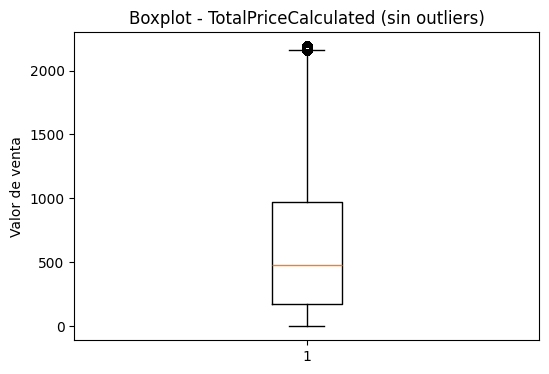

In [32]:
plt.figure(figsize=(6,4))
plt.boxplot(sales_sin_outliers['TotalPriceCalculated'].replace([np.inf, -np.inf], np.nan).dropna())
plt.title('Boxplot - TotalPriceCalculated (sin outliers)')
plt.ylabel('Valor de venta')
plt.show()

# Clasificación (Analisis solicitado)

#### A partir de la columna SalesDate, crea una nueva columna que contenga únicamente la hora de la venta. Luego, identifica en qué hora del día se concentran más ventas totales (TotalPriceCalculated). ####

In [34]:
# Extraemos la hora y día de la semana 
sales['SaleHour'] = sales['SalesDate'].dt.hour
sales['TipoDia'] = sales['SalesDate'].dt.dayofweek.map(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

agg_data = sales.groupby(['SaleHour', 'TipoDia'], as_index=False)['TotalPriceCalculated'].sum()

# Hora con mayor volumen de ventas
top_row = agg_data.loc[agg_data['TotalPriceCalculated'].idxmax()]
hora_top, tipo_top, ventas_top = int(top_row['SaleHour']), top_row['TipoDia'], top_row['TotalPriceCalculated']

total_global = sales['TotalPriceCalculated'].sum()
porcentaje_top = (ventas_top / total_global) * 100

print(f" Hora con mayor volumen de ventas: {hora_top}:00 ({tipo_top})")
print(f" Total vendido: {ventas_top:,.2f} ({porcentaje_top:.2f}% del total)\n")

# Ventas totales por hora
ventas_por_hora = (
    sales.groupby('SaleHour', as_index=False)['TotalPriceCalculated']
         .sum()
         .sort_values('TotalPriceCalculated', ascending=False)
)


 Hora con mayor volumen de ventas: 16:00 (Entre semana)
 Total vendido: 129,162,103.51 (2.99% del total)



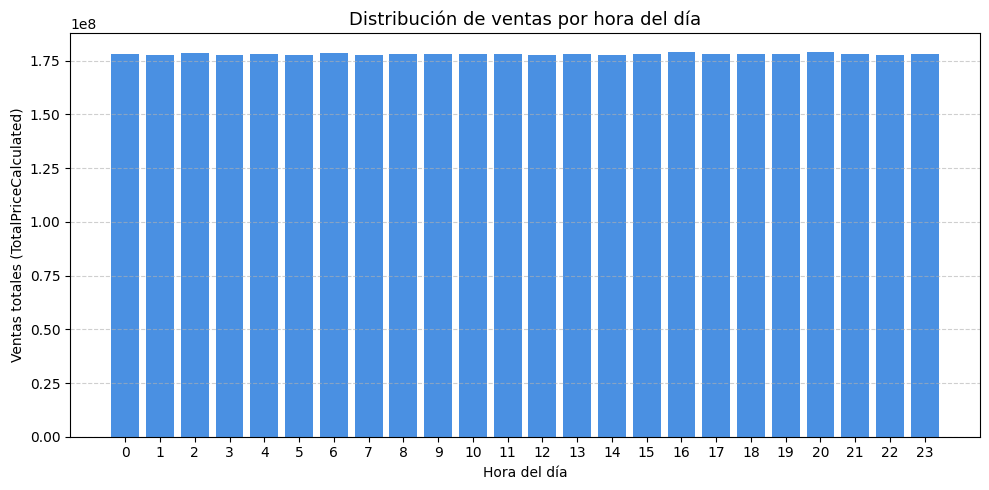

In [35]:
# Gráfico de ventas por hora 
plt.figure(figsize=(10,5))
plt.bar(ventas_por_hora['SaleHour'], ventas_por_hora['TotalPriceCalculated'], color="#4A90E2")
plt.title("Distribución de ventas por hora del día", fontsize=13)
plt.xlabel("Hora del día")
plt.ylabel("Ventas totales (TotalPriceCalculated)")
plt.xticks(range(0,24))
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

#### ¿La empresa vende más durante los días de semana o en el fin de semana? Clasifica cada venta como Entre semana o Fin de semana a partir de SalesDate y compara el total de ventas entre ambos grupos. ¿En cuál se vende más? ####

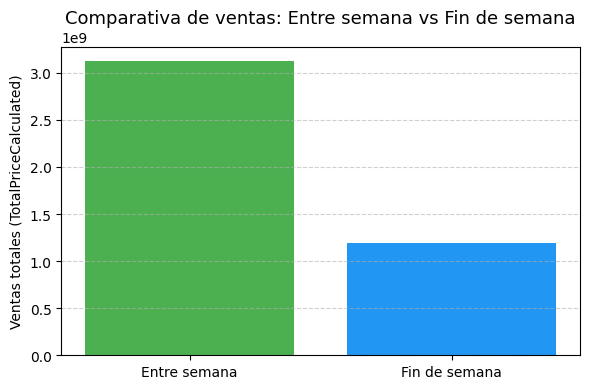

In [37]:
# Comparativa entre semana vs fin de semana 
ventas_por_tipo = sales.groupby('TipoDia', as_index=False)['TotalPriceCalculated'].sum()

plt.figure(figsize=(6,4))
plt.bar(ventas_por_tipo['TipoDia'], ventas_por_tipo['TotalPriceCalculated'], color=['#4CAF50', '#2196F3'])
plt.title('Comparativa de ventas: Entre semana vs Fin de semana', fontsize=13)
plt.ylabel('Ventas totales (TotalPriceCalculated)')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Trabajo en DataFrame

#### Como parte del proceso de feature engineering, en el mismo DataFrame en el que vienes trabajando, calcula dos nuevas columnas en el dataset de ventas: (1) La edad del empleado al momento de su contratación y (2) años de experiencia al momento de realizar cada venta. Utiliza las columnas BirthDate, HireDate (de la tabla employees) y SalesDate (de la tabla sales). Asegúrate de trabajar con fechas en formato adecuado. ####

In [52]:
# Asegurar que las columnas de fechas sean datetime (Ya fue realizado anteriormente en Limpieza de datos )
employees['BirthDate'] = pd.to_datetime(employees['BirthDate'], errors='coerce')
employees['HireDate'] = pd.to_datetime(employees['HireDate'], errors='coerce')
sales['SalesDate'] = pd.to_datetime(sales['SalesDate'], errors='coerce')

#### Creamos un nuevo DataFrame sales_emp que tiene las fechas de nacimiento y contratación de cada empleado junto con la fecha de la venta. ####

In [55]:
# Unir sales con employees
sales_emp = pd.merge(sales, employees[['EmployeeID', 'BirthDate', 'HireDate']], 
                     on='EmployeeID', how='left')

In [40]:
sales_emp.head()

,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price,TotalPriceCalculated,IsOutlier,SaleHour,TipoDia,BirthDate,HireDate
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,309.63590,0,7.0,Entre semana,1987-01-13,2013-06-22 13:20:18.080
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,437.82200,0,16.0,Entre semana,1951-07-07,2017-02-10 11:21:26.650
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0,79.0184,1896.44160,0,19.0,Entre semana,1963-04-18,2011-12-12 10:43:52.940
3,4,8,73966,176,19,0.2,0.0,2018-04-07 14:43:55.420,R3DR9MLD5NR76VO17ULE,81.3167,1236.01384,0,14.0,Fin de semana,1956-12-13,2014-10-14 23:12:53.420
4,5,10,32653,310,9,0.0,0.0,2018-02-12 15:37:03.940,4BGS0Z5OMAZ8NDAFHHP3,79.9780,719.80200,0,15.0,Entre semana,1963-12-30,2012-07-23 15:02:12.640


## Trabajo en DataFrame ##

 #### Como parte del proceso de feature engineering, en el mismo DataFrame en el que vienes trabajando, calcula dos nuevas columnas en el dataset de ventas: (1) La edad del empleado al momento de su contratación y (2) años de experiencia al momento de realizar cada venta. Utiliza las columnas BirthDate, HireDate (de la tabla employees) y SalesDate (de la tabla sales). Asegúrate de trabajar con fechas en formato adecuado. ####

In [58]:
# Calcular edad al momento de contratación
sales_emp['EdadAlContratar'] = (sales_emp['HireDate'] - sales_emp['BirthDate']).dt.days / 365.25

# Calcular años de experiencia al momento de la venta
sales_emp['AniosExperiencia'] = (sales_emp['SalesDate'] - sales_emp['HireDate']).dt.days / 365.25

In [59]:
sales_emp[['EmployeeID', 'BirthDate', 'HireDate', 'SalesDate', 'EdadAlContratar', 'AniosExperiencia']].head(10)

,EmployeeID,BirthDate,HireDate,SalesDate,EdadAlContratar,AniosExperiencia
0,6,1987-01-13,2013-06-22 13:20:18.080,2018-02-05 07:38:25.430,26.439425,4.621492
1,16,1951-07-07,2017-02-10 11:21:26.650,2018-02-02 16:03:31.150,65.598905,0.977413
2,13,1963-04-18,2011-12-12 10:43:52.940,2018-05-03 19:31:56.880,48.651608,6.390144
3,8,1956-12-13,2014-10-14 23:12:53.420,2018-04-07 14:43:55.420,57.834360,3.477070
4,10,1963-12-30,2012-07-23 15:02:12.640,2018-02-12 15:37:03.940,48.563997,5.557837
5,13,1963-04-18,2011-12-12 10:43:52.940,2018-02-07 10:33:24.990,48.651608,6.154689
6,14,1961-09-05,2016-07-11 00:57:58.340,2018-03-02 23:09:58.750,54.847365,1.639973
7,3,1963-02-09,2012-03-30 18:55:23.270,2018-01-17 13:41:38.460,49.136208,5.798768
8,16,1951-07-07,2017-02-10 11:21:26.650,2018-04-27 06:19:58.570,65.598905,1.204654
9,22,1952-03-02,2015-11-25 18:18:23.480,2018-03-26 22:12:08.530,63.731691,2.332649


In [60]:
print(" - Estadísticas de Edad al Contratar:")
print(sales_emp['EdadAlContratar'].describe())

print("\n- Estadísticas de Años de Experiencia:")
print(sales_emp['AniosExperiencia'].describe())

 - Estadísticas de Edad al Contratar:
count    6.758125e+06
mean     4.571585e+01
std      1.194729e+01
min      2.086516e+01
25%      4.057221e+01
50%      4.856400e+01
75%      5.484736e+01
max      6.559890e+01
Name: EdadAlContratar, dtype: float64

- Estadísticas de Años de Experiencia:
count    6.690599e+06
mean     4.550142e+00
std      2.136773e+00
min      8.870637e-01
25%      2.362765e+00
50%      4.700890e+00
75%      6.327173e+00
max      8.208077e+00
Name: AniosExperiencia, dtype: float64


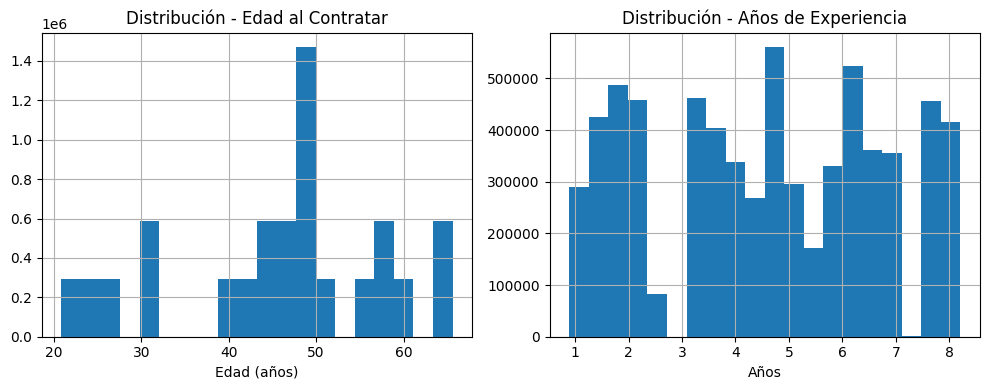

In [46]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sales_emp['EdadAlContratar'].hist(bins=20)
plt.title('Distribución - Edad al Contratar')
plt.xlabel('Edad (años)')

plt.subplot(1,2,2)
sales_emp['AniosExperiencia'].hist(bins=20)
plt.title('Distribución - Años de Experiencia')
plt.xlabel('Años')
plt.tight_layout()
plt.show()

 ## Dataset 

#### Prepara un único dataset definitivo para modelado que combine información relevante de las tablas disponibles. Incluye las features que se han calculado previamente. Aplica transformaciones adecuadas a las variables categóricas y a las variables numéricas (si lo consideras necesario) para dejar los datos listos para ser utilizados por un modelo de machine learning. Justifica las transformaciones realizadas.La(opens in a new tab) variable objetivo es TotalPriceCalculated, por lo que debe quedar sin transformaciones.

#### Solo consideramos las columnas mas importantes de cada tabla

In [61]:
# Merge con products 
final_df = pd.merge(sales_emp, products[['ProductID', 'ProductName', 'Price', 'CategoryID', 'Class', 'Resistant', 'IsAllergic']],
                    on='ProductID', how='left')

# Merge con categories 
final_df = pd.merge(final_df, categories[['CategoryID', 'CategoryName']], 
                    on='CategoryID', how='left')

# Merge con customers 
final_df = pd.merge(final_df, customers[['CustomerID', 'CityID']], 
                    on='CustomerID', how='left')

# Merge con cities 
final_df = pd.merge(final_df, cities[['CityID', 'CityName', 'CountryID']], 
                    on='CityID', how='left')

# Merge con countries 
final_df = pd.merge(final_df, countries[['CountryID', 'CountryName']], 
                    on='CountryID', how='left')

# Resultado
print(final_df.shape)
final_df.head(3)


(6758125, 26)


,SalesID,EmployeeID,CustomerID,ProductID,Quantity,Discount,TotalPrice,SalesDate,TransactionNumber,Price_x,...,Price_y,CategoryID,Class,Resistant,IsAllergic,CategoryName,CityID,CityName,CountryID,CountryName
0,1,6,27039,381,7,0.0,0.0,2018-02-05 07:38:25.430,FQL4S94E4ME1EZFTG42G,44.2337,...,44.2337,1.0,High,Unknown,Unknown,Confections,54,Albuquerque,32,United States
1,2,16,25011,61,7,0.0,0.0,2018-02-02 16:03:31.150,12UGLX40DJ1A5DTFBHB8,62.5460,...,62.5460,8.0,Low,Durable,FALSE,Grain,71,Phoenix,32,United States
2,3,13,94024,23,24,0.0,0.0,2018-05-03 19:31:56.880,5DT8RCPL87KI5EORO7B0,79.0184,...,79.0184,11.0,Medium,Durable,TRUE,Produce,2,Buffalo,32,United States


#### Variables categóricas (texto)

#### Identificar variables categóricas

In [ ]:
cat_cols = final_df.select_dtypes(include='object').columns.tolist()
cat_cols

['TransactionNumber',
 'ProductName',
 'Class',
 'Resistant',
 'IsAllergic',
 'CategoryName',
 'CityName',
 'CountryName']

#### Aplicamos One-Hot Encoding

In [63]:
final_encoded = pd.get_dummies(final_df, columns=cat_cols, drop_first=True)

print("Shape final:", final_encoded.shape)
final_encoded.head(3)

MemoryError: Unable to allocate 41.5 TiB for an array with shape (6758125, 6758125) and data type bool